# CLaSP Embedding Visualization

This notebook demonstrates how to:
1. Extract embeddings from crystal structures using a pretrained CLaSP model
2. Visualize embeddings using t-SNE
3. Explore similarities with text queries
4. Perform clustering and keyword generation

## Requirements & Assumptions
- **Pretrained weights** and **dataset artifacts** already exist on your machine.
- Paths like `config_path`, `checkpoint_file`, and `dataset_rootpath` are expected to point to local files/folders that you have already prepared.
- If you want to run end-to-end training, please refer to the README.md; this notebook focuses on visualization.


In [ ]:
import sys  
sys.path.append("/workspace")

import os
import pandas as pd  
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch  
from tqdm import tqdm
from torch.utils.data import random_split  
from torch_geometric.loader import DataLoader  
from transformers import BertTokenizer
from torch_geometric.loader import DataLoader  
from hydra import initialize, compose
from torch.nn.functional import cosine_similarity

from dataloaders.dataset import ClaspDataset
from dataloaders.common import seed_worker  
from models.metric_learning import ClaspModel  
from train_pretraining import load_metadata_and_embeddings  
from models.utils import normalize_embedding
from utils.embedding_utils import predict_embeddings
from openTSNE import TSNE

In [2]:
class SimpleStruct:
    def __init__(self, tokenized_title):
        self.tokenized_title = tokenized_title
        
def encode_texts(text_list):
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    
    data = SimpleStruct({
        "input_ids": encoded_input['input_ids'].to(device),
        "attention_mask": encoded_input['attention_mask'].to(device)
    })
    
    with torch.no_grad():
        embedding = text_encoder(data).cpu()
    if cfg.embedding_normalize is not None:
        embedding = normalize_embedding(embedding, cfg.embedding_normalize)
        
    return embedding

In [ ]:
target_dataset = "test"

print(f"target dataset: {target_dataset}")
print("loading metadata...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metadata_and_embeddings = load_metadata_and_embeddings(load_path='/workspace/data/cod_metadata_20240331.csv',
                                                   cod_basepath='/cod')  
dataset_rootpath = '/workspace/data/cod_full_20240331'
print(f"dataset_rootpath: {dataset_rootpath}")

dataset = ClaspDataset(input_dataframe=metadata_and_embeddings, 
                    tokenizer=None, 
                    max_token_length=64,
                    root=dataset_rootpath)  

dataset_size = len(dataset)  
train_size = int(0.8 * dataset_size)  
val_size = int(0.1 * dataset_size)  
test_size = dataset_size - train_size - val_size  

generator = torch.Generator().manual_seed(42)  
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)  

if target_dataset == "val":
    df = pd.DataFrame({"titles":[val_dataset.dataset.data["title"][i] for i in val_dataset.indices], 
                "id": [val_dataset.dataset.data["material_id"][i] for i in val_dataset.indices]})
    dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=2, drop_last=False,
                        pin_memory=True,persistent_workers=True,
                        worker_init_fn=seed_worker) 
elif target_dataset == "test":
    df = pd.DataFrame({"titles":[test_dataset.dataset.data["title"][i] for i in test_dataset.indices], 
                "id": [test_dataset.dataset.data["material_id"][i] for i in test_dataset.indices]})
    dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=2, drop_last=False,
                        pin_memory=True,persistent_workers=True,
                        worker_init_fn=seed_worker) 


In [13]:
len(train_dataset)

324838

In [15]:
len(val_dataset)

40604

In [16]:
len(test_dataset)

40606

In [ ]:

config_path = "../outputs/ft_s3_m05_lr1e-6_ep2050/13-36-10/version_0/"
checkpoint_dir = "{config_path}/model_checkpoint/"

checkpoint_file = 'epoch=2039-step=38161.ckpt'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
print(f"check point: {checkpoint_path}")
with initialize(config_path, version_base='1.1'):
    cfg = compose(config_name="hparams")
    cfg.freeze_text_encoders = True

model = ClaspModel.load_from_checkpoint(checkpoint_path, cfg=cfg, train_loader=None, val_loader=None)
model.to(device)
model.eval()

tokenizer = BertTokenizer.from_pretrained(cfg.hf_textencoder_model_id)
text_encoder = model.model_text.to(device)
output_cry, output_text = predict_embeddings(model, dataloader, device)

In [ ]:
tsne = TSNE(n_components=2, initialization="pca", metric="euclidean", n_jobs=-1, random_state=42, perplexity=100)
output_cry_2d = tsne.fit(output_cry)

output_text_2d = tsne.fit(output_text)

output_cry_2d_0 ,output_cry_2d_1 = output_cry_2d[:, 0], output_cry_2d[:, 1]
output_text_2d_0 ,output_text_2d_1 = output_text_2d[:, 0], output_text_2d[:, 1]
title_dict = None

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


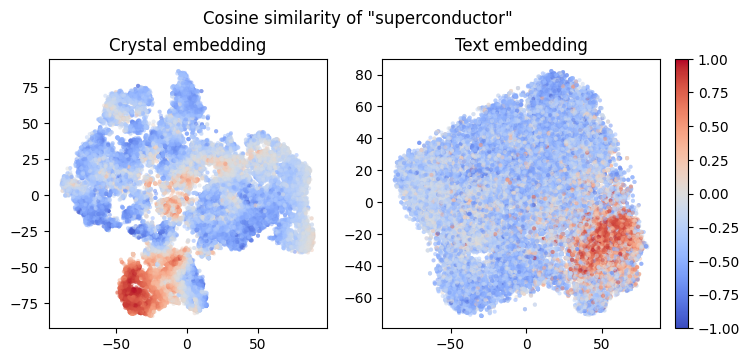

In [ ]:

text = "superconductor"
color_values = cosine_similarity(output_cry, encode_texts(text))

figsize = (9.5, 3.5) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=100)

scatter0 = axes[0].scatter(output_cry_2d_0, output_cry_2d_1, s=8, linewidths=0.1, alpha=0.5, c=color_values, cmap="coolwarm")
axes[0].set_title(title_dict['crystal'] if title_dict is not None and 'crystal' in title_dict else "Crystal embedding")

scatter1 = axes[1].scatter(output_text_2d_0, output_text_2d_1, s=8, linewidths=0.1, alpha=0.5, c=color_values, cmap="coolwarm")
axes[1].set_title(title_dict['text'] if title_dict is not None and 'text' in title_dict else "Text embedding")

norm = mpl.colors.Normalize(vmax=1, vmin=-1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
plt.colorbar(sm, ax=axes, pad=0.02)
plt.suptitle(f'Cosine similarity of "{text}"',y=1.02, x=0.45);

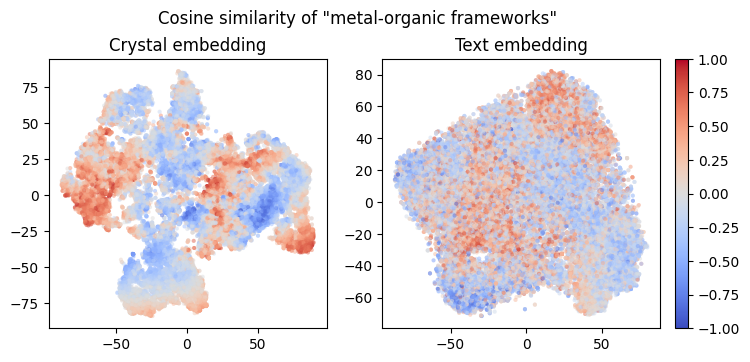

In [ ]:
text = "metal-organic frameworks"
color_values = cosine_similarity(output_cry, encode_texts(text))

figsize = (9.5, 3.5) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=100)

scatter0 = axes[0].scatter(output_cry_2d_0, output_cry_2d_1, s=8, linewidths=0.1, alpha=0.5, c=color_values, cmap="coolwarm")
axes[0].set_title(title_dict['crystal'] if title_dict is not None and 'crystal' in title_dict else "Crystal embedding") # タイトル指定可

scatter1 = axes[1].scatter(output_text_2d_0, output_text_2d_1, s=8, linewidths=0.1, alpha=0.5, c=color_values, cmap="coolwarm")
axes[1].set_title(title_dict['text'] if title_dict is not None and 'text' in title_dict else "Text embedding") # タイトル指定可

norm = mpl.colors.Normalize(vmax=1, vmin=-1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
plt.colorbar(sm, ax=axes, pad=0.02)
plt.suptitle(f'Cosine similarity of "{text}"',y=1.02, x=0.45);

# Clustering and keyword (place name) generation

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)

kmeans.fit(output_cry.numpy())
km_labels = kmeans.labels_
cluster_centers = output_cry_2d.transform(kmeans.cluster_centers_)

df["km_label"] = km_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
with open('../api_keys/gemini_key.txt', mode="r") as f:
    gemini_key = f.read()

import google.generativeai as genai
genai.configure(api_key=gemini_key)

safety_settings = [
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE"
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE"
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE"
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE"
    }
]

# note: you should use gemini 2.5 instead of 1.5
gemini_model = genai.GenerativeModel('gemini-1.5-pro-latest', safety_settings=safety_settings)
import json
import time
def parse_text_to_dict(text):
    try:
        json_str = text.strip('```').strip('json\n')
        parsed_dict = json.loads(json_str)
        return parsed_dict
    except json.JSONDecodeError as e:
        print("JSON decoding failed: ", e)
        return None
        

def extract_keywords_with_gemini(df, prompt_template, gemini_model, num_cluster_k):
    keywords = []
    for label in tqdm(range(num_cluster_k)):  # Assuming there are 20 km_labels from 0 to 19
        titles = [txt + '\n' for txt in df[df['km_label'] == label]["titles"]]        
        prompt = (
            f"{prompt_template}\n"
            f"{titles}"
        )        
        response = gemini_model.generate_content(prompt)
        # Parse the response and extract the keyword
        parsed_dict = parse_text_to_dict(response.text)
        print(f"cluster num:{label}, keywords {parsed_dict['keyword']}")
        keywords.append(parsed_dict['keyword'])
        time.sleep(1)

    # Returning the result as a JSON string
    return keywords

In [ ]:
prompt = f"The following are titles of papers on the crystal structures of certain groups of substances. Name one keyword that describes these substances. Present the result in json format, showing with the key 'keyword'. Do not include the word 'crystal structure' or measurement methods (e.g., X-ray diffraction) in the keyword. Avoid abstract expressions like inorganic material or salt, and use as specific a keyword as possible."

keywords = extract_keywords_with_gemini(df, prompt, gemini_model, num_cluster_k=df["km_label"].max()+1)

  0%|                                                   | 0/20 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1725252132.386192   15435 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


cluster num:0, keywords heterocycles


  5%|██▏                                        | 1/20 [00:05<01:38,  5.20s/it]

cluster num:1, keywords organometallic compounds


 10%|████▎                                      | 2/20 [00:15<02:28,  8.27s/it]

cluster num:2, keywords coordination_complex


 15%|██████▍                                    | 3/20 [00:20<01:55,  6.79s/it]

cluster num:3, keywords metal complexes


 20%|████████▌                                  | 4/20 [00:24<01:32,  5.81s/it]

cluster num:4, keywords lanthanide complex


 25%|██████████▊                                | 5/20 [00:29<01:17,  5.19s/it]

cluster num:5, keywords intermetallic


 30%|████████████▉                              | 6/20 [00:34<01:13,  5.28s/it]

cluster num:6, keywords terpenoid


 35%|███████████████                            | 7/20 [00:39<01:06,  5.14s/it]

cluster num:7, keywords organic compound


 40%|█████████████████▏                         | 8/20 [00:43<00:57,  4.79s/it]

cluster num:8, keywords heterocycle


 45%|███████████████████▎                       | 9/20 [00:49<00:55,  5.07s/it]

cluster num:9, keywords complex


 50%|█████████████████████                     | 10/20 [00:53<00:48,  4.89s/it]

cluster num:10, keywords organic compound


 55%|███████████████████████                   | 11/20 [00:58<00:43,  4.86s/it]

cluster num:11, keywords coordination_polymer


 60%|█████████████████████████▏                | 12/20 [01:03<00:38,  4.82s/it]

cluster num:12, keywords organic_salt


 65%|███████████████████████████▎              | 13/20 [01:16<00:52,  7.47s/it]

cluster num:13, keywords organometallic complex


 70%|█████████████████████████████▍            | 14/20 [01:21<00:39,  6.60s/it]

cluster num:14, keywords chalcogenide


 75%|███████████████████████████████▌          | 15/20 [01:25<00:29,  5.80s/it]

cluster num:15, keywords organometallic complex


 80%|█████████████████████████████████▌        | 16/20 [01:28<00:20,  5.20s/it]

cluster num:16, keywords organometallic complexes


 85%|███████████████████████████████████▋      | 17/20 [01:43<00:24,  8.12s/it]

cluster num:17, keywords oxides


 90%|█████████████████████████████████████▊    | 18/20 [01:48<00:14,  7.03s/it]

cluster num:18, keywords phosphates


 95%|███████████████████████████████████████▉  | 19/20 [01:52<00:06,  6.05s/it]

cluster num:19, keywords mineral


100%|██████████████████████████████████████████| 20/20 [02:08<00:00,  6.45s/it]


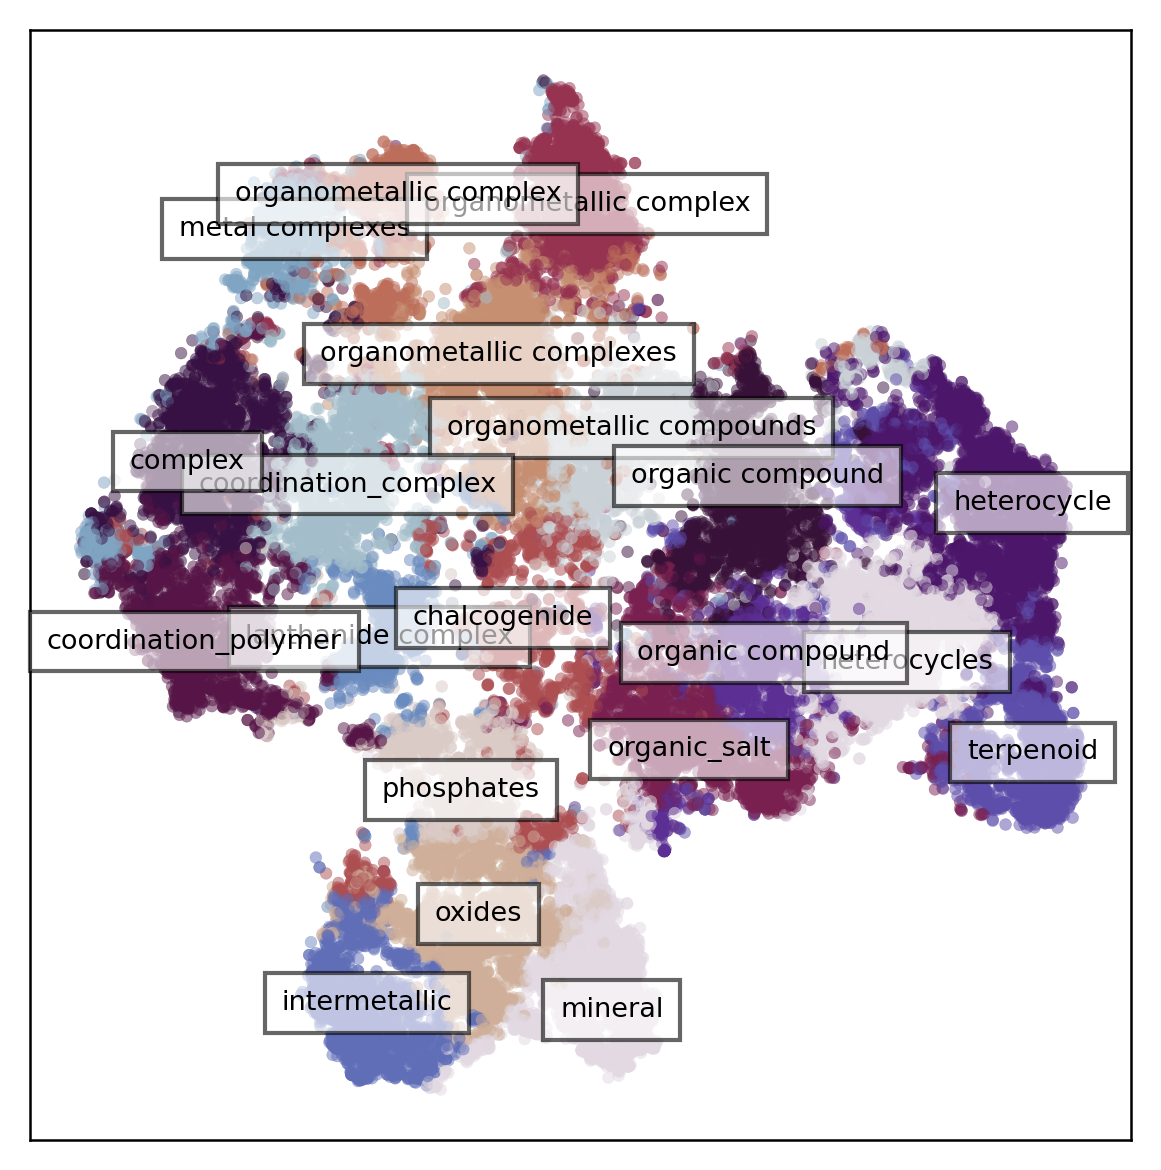

In [ ]:
color_values = df["km_label"]

plt.figure(figsize=(4, 4), dpi=300, linewidth=0.1)
scatter = plt.scatter(output_cry_2d_0, output_cry_2d_1, s=8, linewidths=0.1, alpha=0.5, c=color_values, cmap="twilight")
scatter.set_rasterized(True)

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.6) 

for i in range(df["km_label"].max()+1):
    plt.text(cluster_centers[i, 0],cluster_centers[i, 1,],
             keywords[i],
             fontsize=6.5,
             ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.6))  # text background
plt.xticks([])  
plt.yticks([]) 
plt.tight_layout()